- Code  
&ensp; : Corr_Weather_day - 날씨(KMA ASOS) / DATE(KASI) / Energy Usage 변수에 대한  
&ensp;&ensp; 자체 상관계수  
  
- Desc  
: Date/Weather/Holiday/SN(DHW) Data에 대한 Correlation 분석
  
- Date  
&ensp; : 2023-06-20 Created  
&ensp; : 2024-01-08 활용을 위해 개선  
- DATA  
&emsp; <"Input">  
1) DATA_SN_Weather_Date_Holiday_24h_2023-06-20.csv  
&emsp;- Period :   
&emsp;- Interval  
&emsp;&emsp;:   

&emsp; <"Output">  
1) None  
&emsp;- Columns :  
&emsp;- Period :     
&emsp;- Interval :    

In [1]:
## 필요 Module 설치
# !pip install --upgrade category_encoders
# !pip install gdown
# !pip install kaggle

### 0. Init

In [2]:
#region Basic_Import
## Basic
import os
os.path.dirname(os.path.abspath('__file__'))
import sys
sys.path.append(os.path.dirname(os.path.abspath(os.path.dirname('__file__'))))
import warnings
warnings.filterwarnings('ignore')

import numpy as np, pandas as pd
from pandas import DataFrame, Series

from scipy import stats

## Excel/CSV
import openpyxl, xlrd

import urllib
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus

from selenium import webdriver
from selenium.webdriver.chrome.service import Service

from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

## Init.
pd.options.display.float_format = '{:.10f}'.format
#endregion Basic_Import

In [3]:
## Import_Local (현재 프로그램에서 미사용)
from Src_Dev_Common import DEV_Common_Data_Datetime as com_date
from Src_Dev_Common import DEV_KASI_Holiday as com_Holi
from Src_Dev_Common import DEV_KMA_Weather_ASOS as com_KMA

# from DEV_Common_Data_Preprocessing import resample_by_last, del_outlier_Usages
# from DEV_Common_Data_Visualization import visualization_df
# from DEV_KMA_Weather_ASOS import KMA_ASOS_DATA

In [6]:
## Init Config
# Define data root directory
data_dir = "../data/"
print(os.listdir(data_dir))

['ASOS_2023_119.csv', 'ASOS_META_관측지점정보_20230525170502.csv', 'Cheongju_Weekday_2023-07-23.csv', 'Cheongju_Weekend_2023-07-23.csv', 'Data_05-03-01_Intergrated_cj_2023-07-19.csv', 'DATA_2017_2022.csv', 'DATA_2017_2022_ColDel.csv', 'DATA_2020_2022.csv', 'Data_2023-07-19_01-01_Energy_CJ.csv', 'Data_2023-07-19_01-02_Energy_SJ.csv', 'Data_2023-07-19_01_Energy.csv', 'Data_2023-07-19_02_Weather_ASOS.csv', 'Data_2023-07-19_03_Weather_Air.csv', 'Data_2023-07-19_04_Date.csv', 'Data_2023-07-19_05-01-01_Intergrated_cj.csv', 'Data_2023-07-19_05-01-02_Intergrated_sj.csv', 'Data_2023-07-19_05-02-01_Intergrated_cj.csv', 'Data_2023-07-19_05-02-01_Intergrated_sj.csv', 'Data_2023-07-19_05-03-01_Intergrated_cj.csv', 'Data_2023-07-19_05-03-02_Intergrated_sj.csv', 'Data_2023-07-19_05-03_Intergrated.csv', 'Data_2023-07-19_05_Intergrated.csv', 'DATA_CALENDAR.csv', 'DATA_CALENDAR_2nd_intergrated.csv', 'DATA_CALENDAR_Intergrated.csv', 'DATA_CAL_HOLIDAY.csv', 'DATA_CAL_HOLIDAY_24H.csv', 'DATA_CAL_Weather_Energy_2

### 1. Data Load

In [ ]:
## Local Dataset
## 난방
## 원본 데이터
# path = "IITP_HEAT_20210101-20211231_20221011.csv"
## 0이 제거된 데이터
str_fileName = "DATA_SN_Weather_Date_Holiday_24h_2023-06-20.csv"
df = pd.read_csv(data_dir + str_fileName)

## 'DATE' 컬럼의 데이터 형식을 datetime으로 변경
# df['HEAT_METER_DATE'] = pd.to_datetime(df['HEAT_METER_DATE'])
df

,DHW_METER_DATE,Year,Month,Day,day_of_the_week,code_day_of_the_week,rest_YN,name_of_holiday,dist_from_holiday,Hour,...,PM25,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,DHW consumption
0,2017-11-01 00:00:00,2017,11,1,Wednesday,3,0,-,3,0,...,36.105263,9.9,1019.5,1023.7,0.0,0.00,8.000000,2.0,555.0,0.8396
1,2017-11-01 01:00:00,2017,11,1,Wednesday,3,0,-,3,1,...,35.157895,10.4,1019.3,1023.5,0.0,0.00,8.666667,2.0,579.0,0.8286
2,2017-11-01 02:00:00,2017,11,1,Wednesday,3,0,-,3,2,...,34.210526,10.3,1018.8,1023.0,0.0,0.00,9.333333,6.0,506.0,0.7637
3,2017-11-01 03:00:00,2017,11,1,Wednesday,3,0,-,3,3,...,33.263158,10.4,1018.6,1022.8,0.0,0.00,10.000000,1.0,527.0,0.7906
4,2017-11-01 04:00:00,2017,11,1,Wednesday,3,0,-,3,4,...,32.315789,10.4,1018.3,1022.5,0.0,0.00,8.000000,4.0,576.0,0.7497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29158,2021-06-30 06:00:00,2021,6,30,Wednesday,3,0,-,3,6,...,21.000000,23.7,1002.8,1007.4,0.0,0.00,9.000000,3.0,552.0,0.0015
29159,2021-06-30 07:00:00,2021,6,30,Wednesday,3,0,-,3,7,...,21.000000,24.0,1002.8,1007.4,0.0,0.20,9.000000,4.0,562.0,0.0014
29160,2021-06-30 08:00:00,2021,6,30,Wednesday,3,0,-,3,8,...,24.000000,24.6,1003.2,1007.7,0.0,0.70,8.000000,0.0,700.0,0.0015
29161,2021-06-30 09:00:00,2021,6,30,Wednesday,3,0,-,3,9,...,25.000000,25.2,1003.7,1008.2,0.0,0.95,9.000000,0.0,678.0,0.0015


In [ ]:
## 데이터 확인
print(df.shape)
df.isnull().sum()

(29163, 34)


DHW_METER_DATE          0
Year                    0
Month                   0
Day                     0
day_of_the_week         0
code_day_of_the_week    0
rest_YN                 0
name_of_holiday         0
dist_from_holiday       0
Hour                    0
temp_outdoor            0
temp_dew_point          0
temp_ground             0
humidity                0
wind_speed              0
wind_direction          0
rainfall                0
snowfall                0
snowfall_3hr            0
SO2                     0
CO                      0
O3                      0
NO2                     0
PM10                    0
PM25                    0
pressure_vapor          0
pressure_area           0
pressure_sea            0
sunshine                0
solar_radiation         0
cloud_total             0
cloud_midlow            0
visual_range            0
DHW consumption         0
dtype: int64

In [ ]:
df = df.drop(labels=['DHW_METER_DATE', 'day_of_the_week', 'name_of_holiday'], axis=1)
print(df.shape)
df.isnull().sum()

(29163, 31)


Year                    0
Month                   0
Day                     0
code_day_of_the_week    0
rest_YN                 0
dist_from_holiday       0
Hour                    0
temp_outdoor            0
temp_dew_point          0
temp_ground             0
humidity                0
wind_speed              0
wind_direction          0
rainfall                0
snowfall                0
snowfall_3hr            0
SO2                     0
CO                      0
O3                      0
NO2                     0
PM10                    0
PM25                    0
pressure_vapor          0
pressure_area           0
pressure_sea            0
sunshine                0
solar_radiation         0
cloud_total             0
cloud_midlow            0
visual_range            0
DHW consumption         0
dtype: int64

In [ ]:
## 상관관계 분석
## 상관관계 변수 생성
df_corr = df.corr()
df_corr.corr()

,Year,Month,Day,code_day_of_the_week,rest_YN,dist_from_holiday,Hour,temp_outdoor,temp_dew_point,temp_ground,...,PM25,pressure_vapor,pressure_area,pressure_sea,sunshine,solar_radiation,cloud_total,cloud_midlow,visual_range,DHW consumption
Year,1.000000,-0.391578,-0.022780,-0.016996,-0.014709,0.030443,0.034920,0.233822,0.240570,0.242761,...,-0.342465,0.227235,-0.316330,-0.302995,0.034782,0.132486,0.133886,0.098695,0.169601,-0.276816
Month,-0.391578,1.000000,-0.001442,-0.008808,-0.006217,-0.012580,-0.055579,0.351219,0.385437,0.315659,...,-0.295996,0.395619,-0.248676,-0.253112,-0.090036,-0.030443,0.158237,0.131570,0.062336,-0.352079
Day,-0.022780,-0.001442,1.000000,-0.035665,-0.064606,0.044330,-0.053593,0.034424,0.048473,0.020556,...,-0.043944,0.045235,-0.058560,-0.058627,-0.071720,-0.054998,0.040495,0.040064,-0.018944,-0.044863
code_day_of_the_week,-0.016996,-0.008808,-0.035665,1.000000,0.961785,-0.994414,-0.021010,0.011306,0.007101,0.009881,...,-0.025354,0.004537,-0.012639,-0.012897,-0.002321,0.001297,-0.006696,-0.005172,0.017986,-0.011587
rest_YN,-0.014709,-0.006217,-0.064606,0.961785,1.000000,-0.967530,-0.022874,0.019008,0.015171,0.017811,...,-0.037738,0.011464,-0.020258,-0.020522,0.002062,0.005417,-0.017959,-0.019517,0.026587,-0.021847
dist_from_holiday,0.030443,-0.012580,0.044330,-0.994414,-0.967530,1.000000,0.008045,-0.021856,-0.014116,-0.021493,...,0.033244,-0.012036,0.015657,0.016181,-0.012154,-0.016021,0.009963,0.010992,-0.030834,0.020312
Hour,0.034920,-0.055579,-0.053593,-0.021010,-0.022874,0.008045,1.000000,0.222990,0.031273,0.262808,...,-0.340698,0.049868,-0.135783,-0.138890,0.480266,0.479877,-0.182440,-0.238536,0.525122,-0.161808
temp_outdoor,0.233822,0.351219,0.034424,0.011306,0.019008,-0.021856,0.222990,1.000000,0.953544,0.992176,...,-0.632554,0.958627,-0.961614,-0.963819,0.234631,0.503904,0.502853,0.390775,0.169588,-0.994304
temp_dew_point,0.240570,0.385437,0.048473,0.007101,0.015171,-0.014116,0.031273,0.953544,1.000000,0.914624,...,-0.520216,0.996736,-0.968251,-0.968767,-0.041407,0.243712,0.650932,0.554850,-0.068209,-0.963355
temp_ground,0.242761,0.315659,0.020556,0.009881,0.017811,-0.021493,0.262808,0.992176,0.914624,1.000000,...,-0.657889,0.922193,-0.937738,-0.940253,0.344464,0.603376,0.429943,0.318483,0.241947,-0.982906


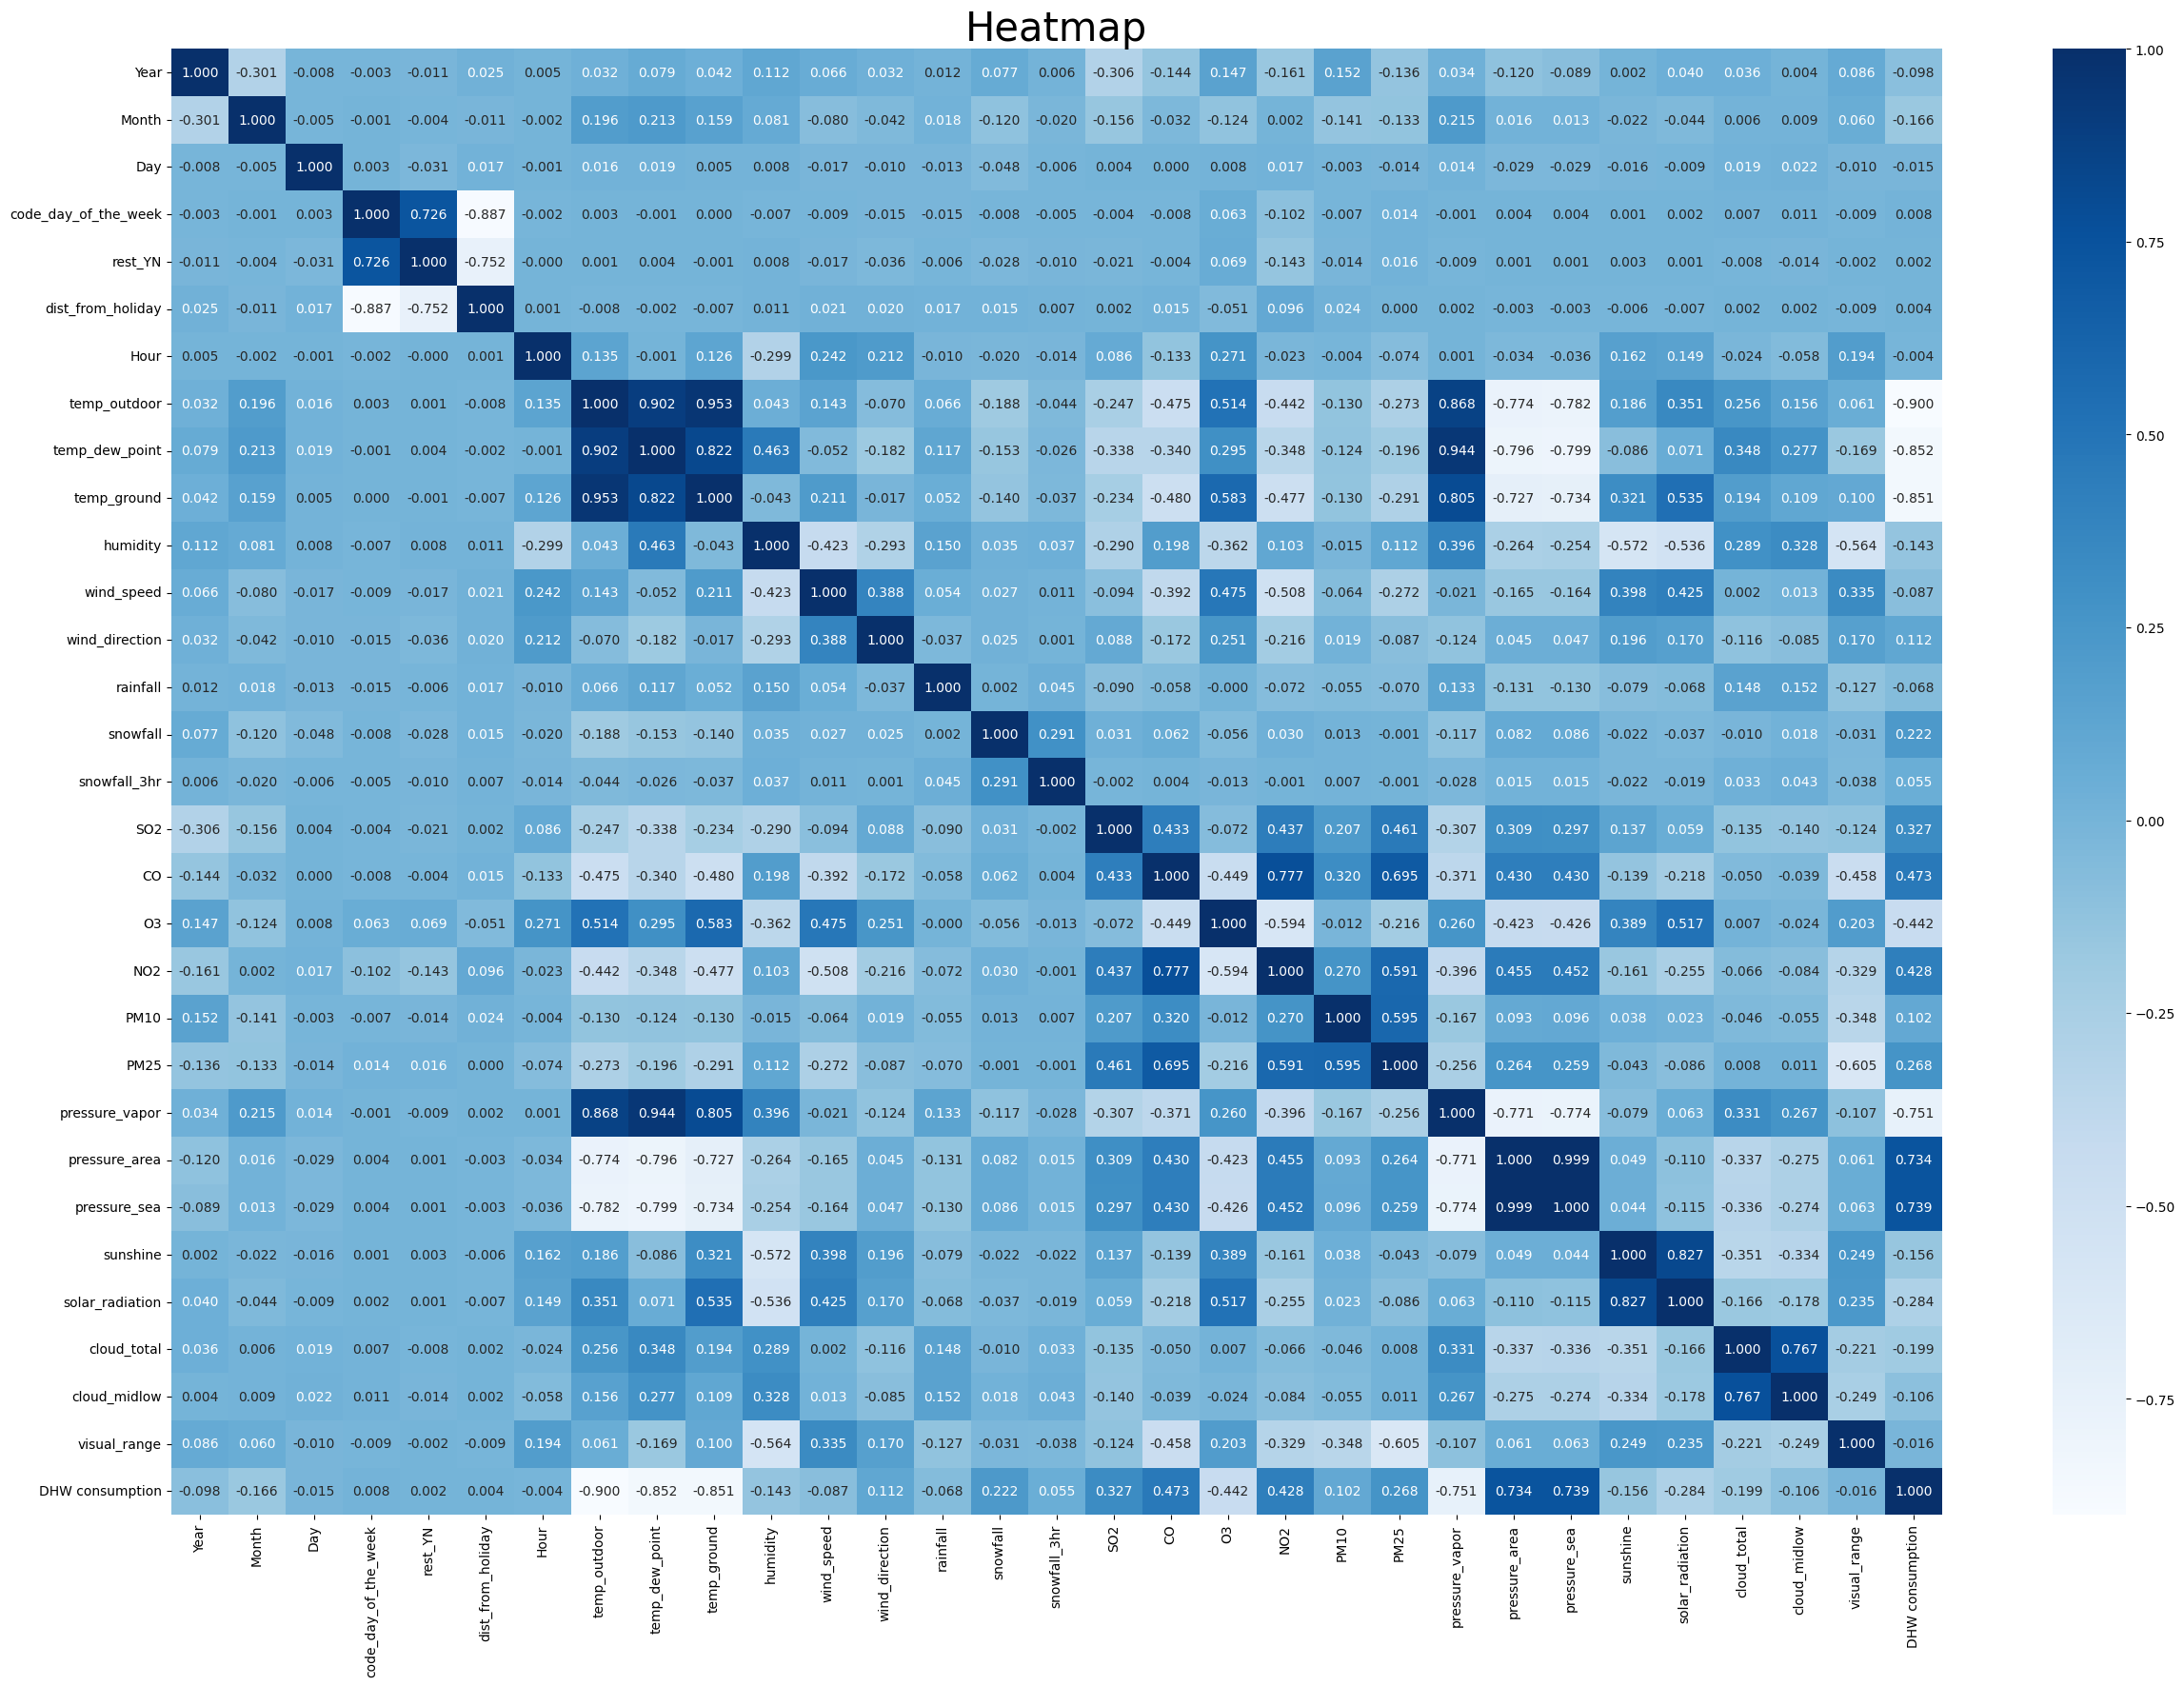

In [ ]:
## Heatmap 분석
plt.figure(figsize=(30,20))
ax = sns.heatmap(df_corr, annot=True, fmt='.3f', cmap='Blues')
plt.title("Heatmap", fontsize=30)
plt.show()

In [ ]:
## Data 취합이 완료되었다면, CSV Export
df_linear_int.to_csv('./data_weather_2nd_interpolated.csv', index = False)